In [2]:
import pandas as pd
import numpy as np
import math
import string
import copy
import warnings
import os
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from tqdm import tqdm
warnings.filterwarnings("ignore")

In [21]:
test_folds = {}

In [23]:
stfold = StratifiedKFold(n_splits=5, shuffle=True)
train_l = list()
val_l = list()
test_l = list()
maxlen = 25
cnt = 0
for train_index, test_index in stfold.split(data['comment'], data['label']):
    cnt += 1
    train = data.iloc[train_index]
    train_x, train_y = train['comment'], train['label']
    tmp = data.iloc[test_index]

    val, test = train_test_split(tmp, test_size=0.5, stratify=tmp['label'])    
    val_x, val_y = val['comment'], val['label']
    test_x, test_y = test['comment'], test['label']    
    
    train_x = vectorizer(np.array([[s] for s in train_x])).numpy()    
    val_x = vectorizer(np.array([[s] for s in val_x])).numpy()
    test_x = vectorizer(np.array([[s] for s in test_x])).numpy()

    train_x = keras.preprocessing.sequence.pad_sequences(train_x, maxlen=maxlen)
    val_x = keras.preprocessing.sequence.pad_sequences(val_x, maxlen=maxlen)
    test_x = keras.preprocessing.sequence.pad_sequences(test_x, maxlen=maxlen)
    

    test_folds[cnt] = (test_x, test_y)
    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = layers.Embedding(input_dim = vocab_size, 
                                       output_dim = emb_dim, 
                                       embeddings_initializer=keras.initializers.Constant(matrix),
                                       trainable=True)
    x = embedding_layer(inputs)
    x = layers.Bidirectional(layers.GRU(32, return_sequences = True, dropout=0.4))(x)
    x = layers.Conv1D(128, kernel_size = 2, padding = "valid", kernel_initializer = "he_uniform")(x)
    avg_pool = layers.GlobalAveragePooling1D()(x)
    max_pool = layers.GlobalMaxPooling1D()(x)
    x = layers.concatenate([avg_pool, max_pool])
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model_path = "logistic_models/{itr:04}".format(itr=cnt)
    checkpoint_path = model_path + "-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    !mkdir logistic_models
    !mkdir $model_path
    
    model.compile(tf.optimizers.Adam(lr=0.0055), "binary_crossentropy", metrics=[  "accuracy", 
                                                                                  tf.keras.metrics.AUC(name='auc')])
    
    
    #create checkpoint to save model
    #with best validation loss
    model.save_weights(checkpoint_path.format(epoch=0))

    checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_auc', verbose=1,
            save_weights_only=True, save_best_only=True, mode='max')
    
    history = model.fit(
                        train_x, train_y, 
                        batch_size=64, epochs=10, 
                        validation_data=(val_x, val_y),
                        callbacks = [checkpoint]
                        )
    
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest)
    
    train_eval = model.evaluate(train_x, train_y)
    val_eval = model.evaluate(val_x, val_y)
    test_eval = model.evaluate(test_x, test_y)
    
    test_l.append(test_eval)
    val_l.append(val_eval)
    train_l.append(train_eval)

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.7410 - auc: 0.8271
Epoch 00001: val_auc improved from -inf to 0.92110, saving model to logistic_models/0001-0001.ckpt
125/125 [==============================] - 23s 183ms/step - loss: 0.4927 - accuracy: 0.7410 - auc: 0.8271 - val_loss: 0.3497 - val_accuracy: 0.8540 - val_auc: 0.9211
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 0.0750 - accuracy: 0.9735 - auc: 0.9961
Epoch 00002: val_auc did not improve from 0.92110
125/125 [==============================] - 22s 172ms/step - loss: 0.0750 - accuracy: 0.9735 - auc: 0.9961 - val_loss: 0.4944 - val_accuracy: 0.8520 - val_auc: 0.9127
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9979 - auc: 0.9996
Epoch 00003: val_auc did not improve from 0.92110
125/125 [==============================] - 26s 208ms/step - loss: 0.0073 - accuracy: 0.9979 - auc: 0.9996 - val_loss: 0.5759 - val_accuracy

In [24]:
test_l = np.array(test_l)
val_l = np.array(val_l)
train_l = np.array(train_l)

print("test avg loss: ", np.mean(test_l[:, 0]), "+/-" ,np.std(test_l[:, 0]))
print("test avg acc: ", np.mean(test_l[:, 1]),  "+/-" ,np.std(test_l[:, 1]))
print("test avg auc: ", np.mean(test_l[:, 2]),  "+/-" ,np.std(test_l[:, 2]))
print('\n')


print("val avg loss: ", np.mean(val_l[:, 0]), "+/-" ,np.std(val_l[:, 0]))
print("val avg acc: ", np.mean(val_l[:, 1]),  "+/-" ,np.std(val_l[:, 1]))
print("val avg auc: ", np.mean(val_l[:, 2]),  "+/-" ,np.std(val_l[:, 2]))

print('\n')


print("train avg loss: ", np.mean(train_l[:, 0]), "+/-" ,np.std(train_l[:, 0]))
print("train avg acc: ", np.mean(train_l[:, 1]),  "+/-" ,np.std(train_l[:, 1]))
print("train avg auc: ", np.mean(train_l[:, 2]),  "+/-" ,np.std(train_l[:, 2]))

test avg loss:  0.3330685615539551 +/- 0.014805507748651319
test avg acc:  0.8648000121116638 +/- 0.0040693983273506085
test avg auc:  0.9288004875183106 +/- 0.0023051569454567637


val avg loss:  0.34439716339111326 +/- 0.011828991825606969
val avg acc:  0.8597999930381774 +/- 0.005912699899702161
val avg auc:  0.9238409876823426 +/- 0.007868199795771793


train avg loss:  0.11767539530992507 +/- 0.01895561543513838
train avg acc:  0.9630750060081482 +/- 0.003950970045376191
train avg auc:  0.9946664690971374 +/- 0.0009434202142433646


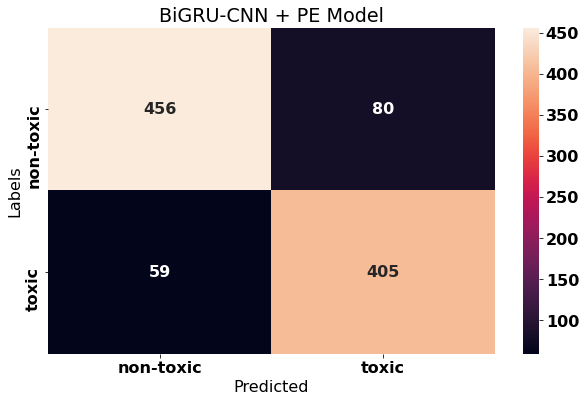

In [25]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd 
from sklearn.metrics import confusion_matrix

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)
pred = np.array([model.predict(test_folds[5][0]) > 0.5], dtype=int).ravel()
cm = confusion_matrix(test_folds[5][1].values, pred)
cm = pd.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10, 6))

sns.heatmap(cm,
            fmt = 'd',
            annot=True)


ax = plt.subplot()
ax.set_xlabel('Predicted')
ax.set_ylabel('Labels')
ax.xaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.yaxis.set_ticklabels(['non-toxic', 'toxic'])
ax.set_title('BiGRU-CNN + PE Model')
plt.show()

In [26]:
plt.savefig('bigru-cnn_pe.png')

<Figure size 432x288 with 0 Axes>